# 07 - Comprehensive Model Comparison

This notebook provides a comprehensive comparison of all forecasting models using walk-forward validation. We evaluate baseline, statistical, and machine learning models on the same dataset with rigorous cross-validation.

## Models Evaluated

**Baseline Models:**
- Naive Model: Predicts the last observed value
- Seasonal Naive Model: Repeats the last weekly pattern
- Moving Average Model: Uses the average of recent values

**Statistical Models:**
- ARIMA: Autoregressive Integrated Moving Average
- Prophet: Facebook's time series forecasting library

**Machine Learning Models:**
- XGBoost: Gradient boosting with lag features
- LightGBM: Light gradient boosting with lag features

## Evaluation Methodology

We use **walk-forward validation** (expanding window) to evaluate models:
- Initial training size: 365 days (captures full yearly seasonality)
- Test size: 7 days (forecast horizon)
- Step size: 7 days (weekly evaluation windows)

This approach ensures:
- No data leakage (models only see past data)
- Multiple evaluation windows for robust metrics
- Realistic simulation of production forecasting

## 1. Setup and Imports

In [1]:
import sys
import warnings
from pathlib import Path
from datetime import date

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Import evaluation tools
from volume_forecast.evaluation import WalkForwardValidator, ModelBenchmark
from volume_forecast.evaluation import mae, rmse, mape, smape

# Import baseline models
from volume_forecast.models import NaiveModel, SeasonalNaiveModel, MovingAverageModel

# Import statistical models
from volume_forecast.models import ARIMAModel, ProphetModel

# Import ensemble model
from volume_forecast.models import EnsembleModel

# Import feature pipeline
from volume_forecast.features import FeaturePipeline

# Import data generator (fallback if data file doesn't exist)
from volume_forecast.data_generation import VolumeGenerator

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Setup complete!")

Setup complete!


In [2]:
# Check for optional ML libraries
XGBOOST_AVAILABLE = False
LIGHTGBM_AVAILABLE = False

try:
    from volume_forecast.models import XGBoostModel
    import xgboost
    XGBOOST_AVAILABLE = True
    print(f"XGBoost available (version {xgboost.__version__})")
except ImportError as e:
    print(f"XGBoost not available: {e}")
    print("  To install: pip install xgboost")

try:
    from volume_forecast.models import LightGBMModel
    import lightgbm
    LIGHTGBM_AVAILABLE = True
    print(f"LightGBM available (version {lightgbm.__version__})")
except ImportError as e:
    print(f"LightGBM not available: {e}")
    print("  To install: pip install lightgbm")

print(f"\nML models will be {'included' if (XGBOOST_AVAILABLE or LIGHTGBM_AVAILABLE) else 'skipped'} in comparison.")

XGBoost available (version 3.1.2)
LightGBM available (version 4.6.0)

ML models will be included in comparison.


## 2. Load Data

In [3]:
# Define data path
data_path = project_root / "data" / "raw" / "synthetic_volumes.csv"

# Load or generate data
if data_path.exists():
    df = pd.read_csv(data_path, parse_dates=["date"])
    print(f"Loaded data from {data_path}")
else:
    print(f"Data file not found at {data_path}. Generating synthetic data...")
    generator = VolumeGenerator(seed=42)
    df = generator.generate(
        start_date=date(2023, 1, 1),
        end_date=date(2024, 12, 31),
        include_events=True
    )
    # Save for future use
    data_path.parent.mkdir(parents=True, exist_ok=True)
    generator.save(df, data_path)
    print(f"Generated and saved data to {data_path}")

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Display basic info
print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"Total days: {len(df)}")
df.head()

Loaded data from C:\Users\juanlu\dev\volume-forecasting-poc\data\raw\synthetic_volumes.csv

Dataset shape: (731, 4)
Date range: 2023-01-01 to 2024-12-31
Total days: 731


,date,daily_logins,daily_deposits,daily_deposit_volume_gbp
0,2023-01-01,59273,9648,267406
1,2023-01-02,39425,7242,234617
2,2023-01-03,45752,6452,234713
3,2023-01-04,49327,7341,224131
4,2023-01-05,37494,7282,204090


In [4]:
# Apply Feature Pipeline with event features
pipeline = FeaturePipeline(
    date_column='date',
    target_columns=['daily_logins'],
    include_events=True,
    include_football=True,
)
df_features = pipeline.fit_transform(df)
print(f"Features: {len(pipeline.get_feature_names())} columns added")
print(f"Feature columns: {pipeline.get_feature_names()}")
print(f"\nDataset shape after feature engineering: {df_features.shape}")
df_features.head()

Features: 46 columns added
Feature columns: ['day_of_week', 'day_of_month', 'month', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'days_to_payday', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'daily_logins_lag_1', 'daily_logins_lag_7', 'daily_logins_lag_14', 'daily_logins_lag_21', 'daily_logins_rolling_mean_7', 'daily_logins_rolling_std_7', 'daily_logins_rolling_mean_14', 'daily_logins_rolling_std_14', 'daily_logins_rolling_mean_30', 'daily_logins_rolling_std_30', 'is_bank_holiday', 'is_racing_event', 'is_tennis_event', 'is_boxing_event', 'is_football_match', 'event_importance', 'event_count', 'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days', 'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days', 'football_tomorrow', 'football_in_2_days', 'football_in_3_days', 'any_event_yesterday', 'any_event_2_days_ago', 'bank_holiday_yesterday', 'bank_holiday_2_days_ago', 'football_yesterday', 'foo

,date,daily_logins,daily_deposits,daily_deposit_volume_gbp,day_of_week,day_of_month,month,week_of_year,is_weekend,is_month_start,is_month_end,days_to_payday,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_sin,week_cos,daily_logins_lag_1,daily_logins_lag_7,daily_logins_lag_14,daily_logins_lag_21,daily_logins_rolling_mean_7,daily_logins_rolling_std_7,daily_logins_rolling_mean_14,daily_logins_rolling_std_14,daily_logins_rolling_mean_30,daily_logins_rolling_std_30,is_bank_holiday,is_racing_event,is_tennis_event,is_boxing_event,is_football_match,event_importance,event_count,any_event_tomorrow,any_event_in_2_days,any_event_in_3_days,bank_holiday_tomorrow,bank_holiday_in_2_days,bank_holiday_in_3_days,football_tomorrow,football_in_2_days,football_in_3_days,any_event_yesterday,any_event_2_days_ago,bank_holiday_yesterday,bank_holiday_2_days_ago,football_yesterday,football_2_days_ago
0,2023-01-01,59273,9648,267406,6,1,1,52,1,1,0,14,-0.7818,0.6235,0.5000,0.8660,0.0000,1.0000,NaN,NaN,NaN,NaN,59273.0000,NaN,59273.0000,NaN,59273.0000,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2023-01-02,39425,7242,234617,0,2,1,1,0,0,0,13,0.0000,1.0000,0.5000,0.8660,0.1205,0.9927,59273.0000,NaN,NaN,NaN,49349.0000,14034.6554,49349.0000,14034.6554,49349.0000,14034.6554,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2023-01-03,45752,6452,234713,1,3,1,1,0,0,0,12,0.7818,0.6235,0.5000,0.8660,0.1205,0.9927,39425.0000,NaN,NaN,NaN,48150.0000,10138.9634,48150.0000,10138.9634,48150.0000,10138.9634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2023-01-04,49327,7341,224131,2,4,1,1,0,0,0,11,0.9749,-0.2225,0.5000,0.8660,0.1205,0.9927,45752.0000,NaN,NaN,NaN,48444.2500,8299.3203,48444.2500,8299.3203,48444.2500,8299.3203,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2023-01-05,37494,7282,204090,3,5,1,1,0,0,0,10,0.4339,-0.9010,0.5000,0.8660,0.1205,0.9927,49327.0000,NaN,NaN,NaN,46254.2000,8697.1624,46254.2000,8697.1624,46254.2000,8697.1624,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


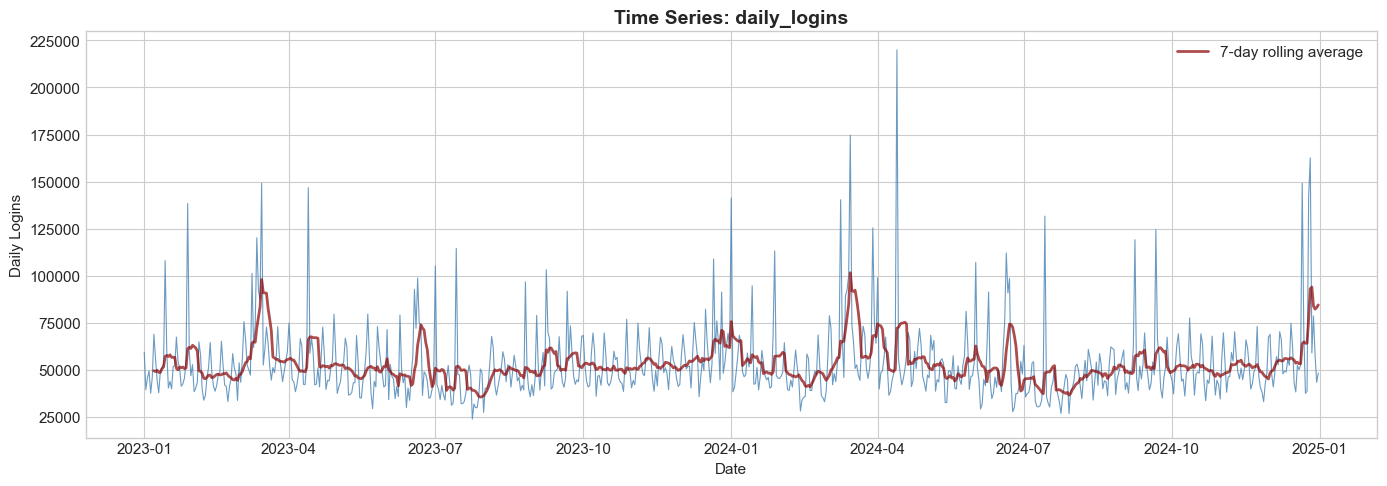

In [5]:
# Quick data visualization
TARGET = 'daily_logins'  # Primary target for forecasting

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['date'], df[TARGET], linewidth=0.8, alpha=0.8, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title(f'Time Series: {TARGET}', fontsize=14, fontweight='bold')

# Add 7-day rolling average
rolling_avg = df[TARGET].rolling(window=7).mean()
ax.plot(df['date'], rolling_avg, linewidth=2, color='darkred', label='7-day rolling average', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()

## 3. Define Models for Comparison

We create instances of all models to be compared. Each model type addresses different forecasting scenarios:

| Model Type | Best For | Complexity |
|------------|----------|------------|
| Naive | Random walk data | Very Low |
| Seasonal Naive | Strong weekly patterns | Low |
| Moving Average | Stable mean, high variance | Low |
| ARIMA | Stationary/differenced series | Medium |
| Prophet | Multiple seasonalities, holidays | Medium |
| XGBoost/LightGBM | Complex non-linear patterns | High |

In [6]:
# Define feature columns for enhanced models

# Features for tree models (external features beyond lags)
EXTERNAL_FEATURES = [
    # Temporal features
    'day_of_week', 'is_weekend', 'day_of_week_sin', 'day_of_week_cos',
    'month', 'month_sin', 'month_cos',
    
    # Rolling statistics
    'daily_logins_rolling_mean_7', 'daily_logins_rolling_mean_14', 'daily_logins_rolling_mean_30',
    'daily_logins_rolling_std_7', 'daily_logins_rolling_std_14', 'daily_logins_rolling_std_30',
    
    # Event flags (same-day)
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    
    # Lead indicators (upcoming events)
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    
    # Lag indicators (past events)
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
]

# Regressors for Prophet (event features only - no rolling stats as Prophet handles trends internally)
PROPHET_REGRESSORS = [
    'is_bank_holiday', 'is_racing_event', 'is_tennis_event',
    'is_boxing_event', 'is_football_match', 'event_importance',
    # Lead indicators
    'any_event_tomorrow', 'any_event_in_2_days', 'any_event_in_3_days',
    'bank_holiday_tomorrow', 'bank_holiday_in_2_days', 'bank_holiday_in_3_days',
    'football_tomorrow', 'football_in_2_days', 'football_in_3_days',
    # Lag indicators
    'any_event_yesterday', 'any_event_2_days_ago',
    'bank_holiday_yesterday', 'bank_holiday_2_days_ago',
    'football_yesterday', 'football_2_days_ago',
]

print(f"External features for tree models: {len(EXTERNAL_FEATURES)}")
print(f"Regressors for Prophet: {len(PROPHET_REGRESSORS)}")

External features for tree models: 34
Regressors for Prophet: 21


In [7]:
# Initialize all models
models = []

# Baseline models
models.append(NaiveModel(name='Naive'))
models.append(SeasonalNaiveModel(season_length=7, name='Seasonal_Naive'))
models.append(MovingAverageModel(window=7, name='MA_7'))
models.append(MovingAverageModel(window=14, name='MA_14'))

# Statistical models
models.append(ARIMAModel(order=(1, 1, 1), name='ARIMA_111'))
models.append(ARIMAModel(order=(2, 1, 2), seasonal_order=(1, 0, 1, 7), name='SARIMA_weekly'))
models.append(ProphetModel(yearly_seasonality=True, weekly_seasonality=True, name='Prophet'))

# Prophet with external regressors (enhanced - default params)
models.append(ProphetModel(
    yearly_seasonality=True, 
    weekly_seasonality=True,
    regressors=PROPHET_REGRESSORS,
    name='Prophet_Enhanced'
))

# Prophet Tuned (best params from Optuna)
prophet_tuned = ProphetModel(
    yearly_seasonality=True,
    weekly_seasonality=True,
    regressors=PROPHET_REGRESSORS,
    seasonality_prior_scale=0.0101,
    seasonality_mode='additive',
    changepoint_prior_scale=0.0117,
    n_changepoints=44,
    changepoint_range=0.797,
    name='Prophet_Tuned'
)
models.append(prophet_tuned)

# ML models (if available)
xgboost_tuned = None
lightgbm_tuned = None

if XGBOOST_AVAILABLE:
    # Basic XGBoost (lag features only)
    models.append(XGBoostModel(n_estimators=100, max_depth=6, lags=[1, 7, 14], name='XGBoost'))
    # Enhanced XGBoost with external features (default params)
    models.append(XGBoostModel(
        n_estimators=100, 
        max_depth=6, 
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='XGBoost_Enhanced'
    ))
    # Tuned XGBoost (best params from Optuna)
    xgboost_tuned = XGBoostModel(
        n_estimators=88,
        max_depth=3,
        learning_rate=0.1105,
        min_child_weight=8,
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='XGBoost_Tuned'
    )
    models.append(xgboost_tuned)

if LIGHTGBM_AVAILABLE:
    # Basic LightGBM (lag features only)
    models.append(LightGBMModel(n_estimators=100, max_depth=-1, lags=[1, 7, 14], name='LightGBM'))
    # Enhanced LightGBM with external features (default params)
    models.append(LightGBMModel(
        n_estimators=100, 
        max_depth=-1, 
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='LightGBM_Enhanced'
    ))
    # Tuned LightGBM (best params from Optuna)
    lightgbm_tuned = LightGBMModel(
        n_estimators=299,
        max_depth=5,
        learning_rate=0.0115,
        num_leaves=52,
        lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES,
        name='LightGBM_Tuned'
    )
    models.append(lightgbm_tuned)

# Ensemble with default params (XGBoost_Tuned + LightGBM_Enhanced + Prophet_Enhanced)
if xgboost_tuned is not None and LIGHTGBM_AVAILABLE:
    ensemble_xgb_default = XGBoostModel(
        n_estimators=88, max_depth=3, learning_rate=0.1105, min_child_weight=8,
        lags=[1, 7, 14], external_features=EXTERNAL_FEATURES, name='Ens_XGB'
    )
    ensemble_lgb_default = LightGBMModel(
        n_estimators=100, max_depth=-1, lags=[1, 7, 14],
        external_features=EXTERNAL_FEATURES, name='Ens_LGB'
    )
    ensemble_prophet_default = ProphetModel(
        yearly_seasonality=True, weekly_seasonality=True,
        regressors=PROPHET_REGRESSORS, name='Ens_Prophet'
    )
    ensemble_default = EnsembleModel(
        models=[ensemble_xgb_default, ensemble_lgb_default, ensemble_prophet_default],
        weighting='inverse_mae',
        name='Ensemble'
    )
    models.append(ensemble_default)

# Ensemble with ALL tuned models (XGBoost_Tuned + LightGBM_Tuned + Prophet_Tuned)
if xgboost_tuned is not None and lightgbm_tuned is not None:
    ensemble_xgb_tuned = XGBoostModel(
        n_estimators=88, max_depth=3, learning_rate=0.1105, min_child_weight=8,
        lags=[1, 7, 14], external_features=EXTERNAL_FEATURES, name='EnsT_XGB'
    )
    ensemble_lgb_tuned = LightGBMModel(
        n_estimators=299, max_depth=5, learning_rate=0.0115, num_leaves=52,
        lags=[1, 7, 14], external_features=EXTERNAL_FEATURES, name='EnsT_LGB'
    )
    ensemble_prophet_tuned = ProphetModel(
        yearly_seasonality=True, weekly_seasonality=True, regressors=PROPHET_REGRESSORS,
        seasonality_prior_scale=0.0101, seasonality_mode='additive',
        changepoint_prior_scale=0.0117, n_changepoints=44, changepoint_range=0.797,
        name='EnsT_Prophet'
    )
    ensemble_tuned = EnsembleModel(
        models=[ensemble_xgb_tuned, ensemble_lgb_tuned, ensemble_prophet_tuned],
        weighting='inverse_mae',
        name='Ensemble_Tuned'
    )
    models.append(ensemble_tuned)

print(f"Models to compare: {len(models)}")
print("\nModel List:")
for i, model in enumerate(models, 1):
    model_type = type(model).__name__
    print(f"  {i}. {model.name} ({model_type})")

Models to compare: 17

Model List:
  1. Naive (NaiveModel)
  2. Seasonal_Naive (SeasonalNaiveModel)
  3. MA_7 (MovingAverageModel)
  4. MA_14 (MovingAverageModel)
  5. ARIMA_111 (ARIMAModel)
  6. SARIMA_weekly (ARIMAModel)
  7. Prophet (ProphetModel)
  8. Prophet_Enhanced (ProphetModel)
  9. Prophet_Tuned (ProphetModel)
  10. XGBoost (XGBoostModel)
  11. XGBoost_Enhanced (XGBoostModel)
  12. XGBoost_Tuned (XGBoostModel)
  13. LightGBM (LightGBMModel)
  14. LightGBM_Enhanced (LightGBMModel)
  15. LightGBM_Tuned (LightGBMModel)
  16. Ensemble (EnsembleModel)
  17. Ensemble_Tuned (EnsembleModel)


## 4. Configure Walk-Forward Validation

Walk-forward validation parameters:
- **initial_train_size=365**: Start with one year of training data to capture yearly seasonality
- **test_size=7**: Each evaluation window is 7 days (our forecast horizon)
- **step_size=7**: Move forward one week between evaluations

In [8]:
# Validation parameters
INITIAL_TRAIN_SIZE = 365  # Days for initial training window
TEST_SIZE = 7             # Forecast horizon (days)
STEP_SIZE = 7             # Step between validation windows (days)

# Create validator
validator = WalkForwardValidator(
    min_train_size=INITIAL_TRAIN_SIZE,
    test_size=TEST_SIZE,
    step_size=STEP_SIZE
)

# Calculate number of validation folds (use df_features which has the same rows as df)
n_folds = validator.get_n_splits(df_features, date_column='date')

print("Walk-Forward Validation Configuration")
print("=" * 50)
print(f"Initial training size: {INITIAL_TRAIN_SIZE} days")
print(f"Test size (horizon):   {TEST_SIZE} days")
print(f"Step size:             {STEP_SIZE} days")
print(f"Number of folds:       {n_folds}")
print(f"\nTotal evaluation days: {n_folds * TEST_SIZE} days")

Walk-Forward Validation Configuration
Initial training size: 365 days
Test size (horizon):   7 days
Step size:             7 days
Number of folds:       52

Total evaluation days: 364 days


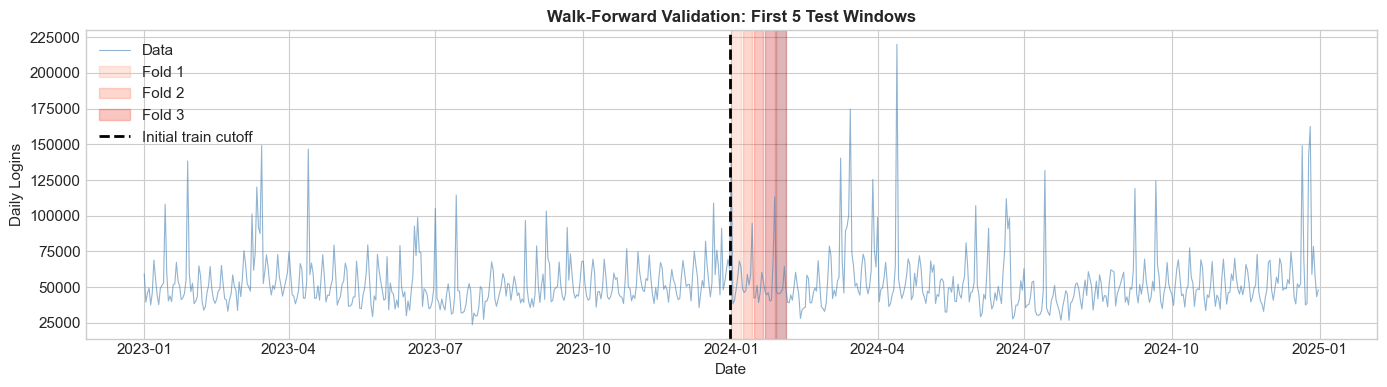

In [9]:
# Visualize validation splits
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(df_features['date'], df_features[TARGET], linewidth=0.8, alpha=0.6, color='steelblue', label='Data')

# Show first few folds
colors = plt.cm.Reds(np.linspace(0.3, 0.9, min(5, n_folds)))
for fold_idx, (train_df, test_df) in enumerate(validator.split(df_features, date_column='date')):
    if fold_idx >= 5:  # Only show first 5 folds for clarity
        break
    ax.axvspan(test_df['date'].iloc[0], test_df['date'].iloc[-1], 
               alpha=0.3, color=colors[fold_idx], label=f'Fold {fold_idx+1}' if fold_idx < 3 else None)

# Mark initial training period
ax.axvline(x=df_features['date'].iloc[INITIAL_TRAIN_SIZE-1], color='black', linestyle='--', 
           linewidth=2, label='Initial train cutoff')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Logins')
ax.set_title('Walk-Forward Validation: First 5 Test Windows', fontsize=12, fontweight='bold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 5. Run Model Benchmark

We use the `ModelBenchmark` class to run walk-forward validation for all models and aggregate results.

In [10]:
# Create benchmark
benchmark = ModelBenchmark(models=models, validator=validator)

print(f"Running benchmark with {len(models)} models across {n_folds} folds...")
print("This may take a few minutes...\n")

# Run the benchmark using df_features (includes event and temporal features)
# Pass feature_columns for enhanced models that use external features
results_df = benchmark.benchmark(
    df_features, 
    target=TARGET, 
    date_column='date',
    feature_columns=EXTERNAL_FEATURES + ['date']
)

print("Benchmark complete!")

Running benchmark with 17 models across 52 folds...
This may take a few minutes...



17:55:44 - cmdstanpy - INFO - Chain [1] start processing


17:55:44 - cmdstanpy - INFO - Chain [1] done processing


Benchmark complete!


In [11]:
# Display raw results
print("\nRaw Benchmark Results:")
print("=" * 80)
results_df


Raw Benchmark Results:


,model_name,mae_mean,mae_std,rmse_mean,rmse_std,mape_mean,mape_std,smape_mean,smape_std
0,Naive,20055.6099,16884.2636,23747.9523,18240.6671,39.7118,39.6421,31.2435,18.9551
1,Seasonal_Naive,14132.1786,10492.6076,21036.9002,16142.8382,23.9778,15.8415,21.8780,11.7192
2,MA_7,14259.2861,8403.1391,18812.9670,12654.1545,25.3844,14.2810,24.1089,10.3362
3,MA_14,13742.1833,7715.1655,18307.2868,12280.1153,24.3801,9.3267,23.4765,8.6900
4,ARIMA_111,14179.6611,7545.4039,18741.8063,12088.7744,26.0139,9.8463,24.3471,8.8660
5,SARIMA_weekly,12130.2076,8805.1713,16340.2201,12707.5820,20.6554,13.3374,20.0314,11.5083
6,Prophet,10256.7147,7684.6129,14196.4606,12109.6877,17.2115,9.7383,16.8672,9.3282
7,Prophet_Enhanced,5615.2975,2572.1905,7364.4803,4503.0177,10.7089,3.8570,10.6365,4.1778
8,Prophet_Tuned,5551.0217,2610.0778,7297.1514,4617.7357,10.6093,3.8679,10.5048,4.0974
9,XGBoost,14907.4088,9634.6077,20163.7992,13176.2679,27.0623,16.9953,24.0165,12.7404


## 6. Results Analysis and Comparison Table

Create a comprehensive comparison table with mean and standard deviation of metrics across all folds.

In [12]:
# Create formatted comparison table
comparison_df = results_df.copy()
comparison_df = comparison_df.set_index('model_name')

# Create formatted columns (mean +/- std)
formatted_results = pd.DataFrame(index=comparison_df.index)

for metric in ['mae', 'rmse', 'mape', 'smape']:
    mean_col = f'{metric}_mean'
    std_col = f'{metric}_std'
    formatted_results[metric.upper()] = comparison_df.apply(
        lambda row: f"{row[mean_col]:.2f} (+/- {row[std_col]:.2f})", axis=1
    )

# Add rank columns based on mean values
for metric in ['mae', 'rmse', 'mape', 'smape']:
    formatted_results[f'{metric.upper()}_Rank'] = comparison_df[f'{metric}_mean'].rank().astype(int)

# Calculate average rank
rank_cols = [col for col in formatted_results.columns if col.endswith('_Rank')]
formatted_results['Avg_Rank'] = formatted_results[rank_cols].mean(axis=1)

# Sort by average rank
formatted_results = formatted_results.sort_values('Avg_Rank')

print("\n" + "=" * 100)
print("MODEL COMPARISON RESULTS (Mean +/- Std across all folds)")
print("=" * 100)
print(f"\nTarget: {TARGET}")
print(f"Forecast Horizon: {TEST_SIZE} days")
print(f"Number of Validation Folds: {n_folds}")
print(f"Total Evaluation Days: {n_folds * TEST_SIZE}\n")

# Display formatted table
display_cols = ['MAE', 'RMSE', 'MAPE', 'SMAPE', 'Avg_Rank']
formatted_results[display_cols]


MODEL COMPARISON RESULTS (Mean +/- Std across all folds)

Target: daily_logins
Forecast Horizon: 7 days
Number of Validation Folds: 52
Total Evaluation Days: 364



,MAE,RMSE,MAPE,SMAPE,Avg_Rank
model_name,,,,,
Ensemble,4901.33 (+/- 2679.22),6295.90 (+/- 4408.16),9.44 (+/- 3.29),9.18 (+/- 3.15),1.2500
XGBoost_Tuned,4919.06 (+/- 2825.59),6287.03 (+/- 4350.50),9.48 (+/- 3.50),9.21 (+/- 3.35),1.7500
Ensemble_Tuned,4998.73 (+/- 2773.61),6537.50 (+/- 4777.00),9.51 (+/- 3.44),9.24 (+/- 3.26),3.0000
XGBoost_Enhanced,5285.34 (+/- 3305.73),6692.52 (+/- 4970.70),10.00 (+/- 3.86),9.71 (+/- 3.48),4.0000
Prophet_Tuned,5551.02 (+/- 2610.08),7297.15 (+/- 4617.74),10.61 (+/- 3.87),10.50 (+/- 4.10),5.7500
LightGBM_Tuned,5678.42 (+/- 3520.53),7787.59 (+/- 6577.19),10.36 (+/- 3.97),10.04 (+/- 3.73),6.2500
Prophet_Enhanced,5615.30 (+/- 2572.19),7364.48 (+/- 4503.02),10.71 (+/- 3.86),10.64 (+/- 4.18),6.7500
LightGBM_Enhanced,5790.37 (+/- 3422.12),7590.22 (+/- 5738.35),10.74 (+/- 4.04),10.40 (+/- 3.75),7.2500
Prophet,10256.71 (+/- 7684.61),14196.46 (+/- 12109.69),17.21 (+/- 9.74),16.87 (+/- 9.33),9.0000


In [13]:
# Create summary statistics table
summary_stats = comparison_df[['mae_mean', 'rmse_mean', 'mape_mean', 'smape_mean']].copy()
summary_stats.columns = ['MAE', 'RMSE', 'MAPE (%)', 'SMAPE (%)']
summary_stats = summary_stats.sort_values('MAE')

print("\nSummary Statistics (Mean Values Only):")
print("-" * 60)
summary_stats.round(2)


Summary Statistics (Mean Values Only):
------------------------------------------------------------


,MAE,RMSE,MAPE (%),SMAPE (%)
model_name,,,,
Ensemble,4901.3300,6295.9000,9.4400,9.1800
XGBoost_Tuned,4919.0600,6287.0300,9.4800,9.2100
Ensemble_Tuned,4998.7300,6537.5000,9.5100,9.2400
XGBoost_Enhanced,5285.3400,6692.5200,10.0000,9.7100
Prophet_Tuned,5551.0200,7297.1500,10.6100,10.5000
Prophet_Enhanced,5615.3000,7364.4800,10.7100,10.6400
LightGBM_Tuned,5678.4200,7787.5900,10.3600,10.0400
LightGBM_Enhanced,5790.3700,7590.2200,10.7400,10.4000
Prophet,10256.7100,14196.4600,17.2100,16.8700


## 7. Visualizations

### 7.1 Bar Charts: Mean Metrics by Model

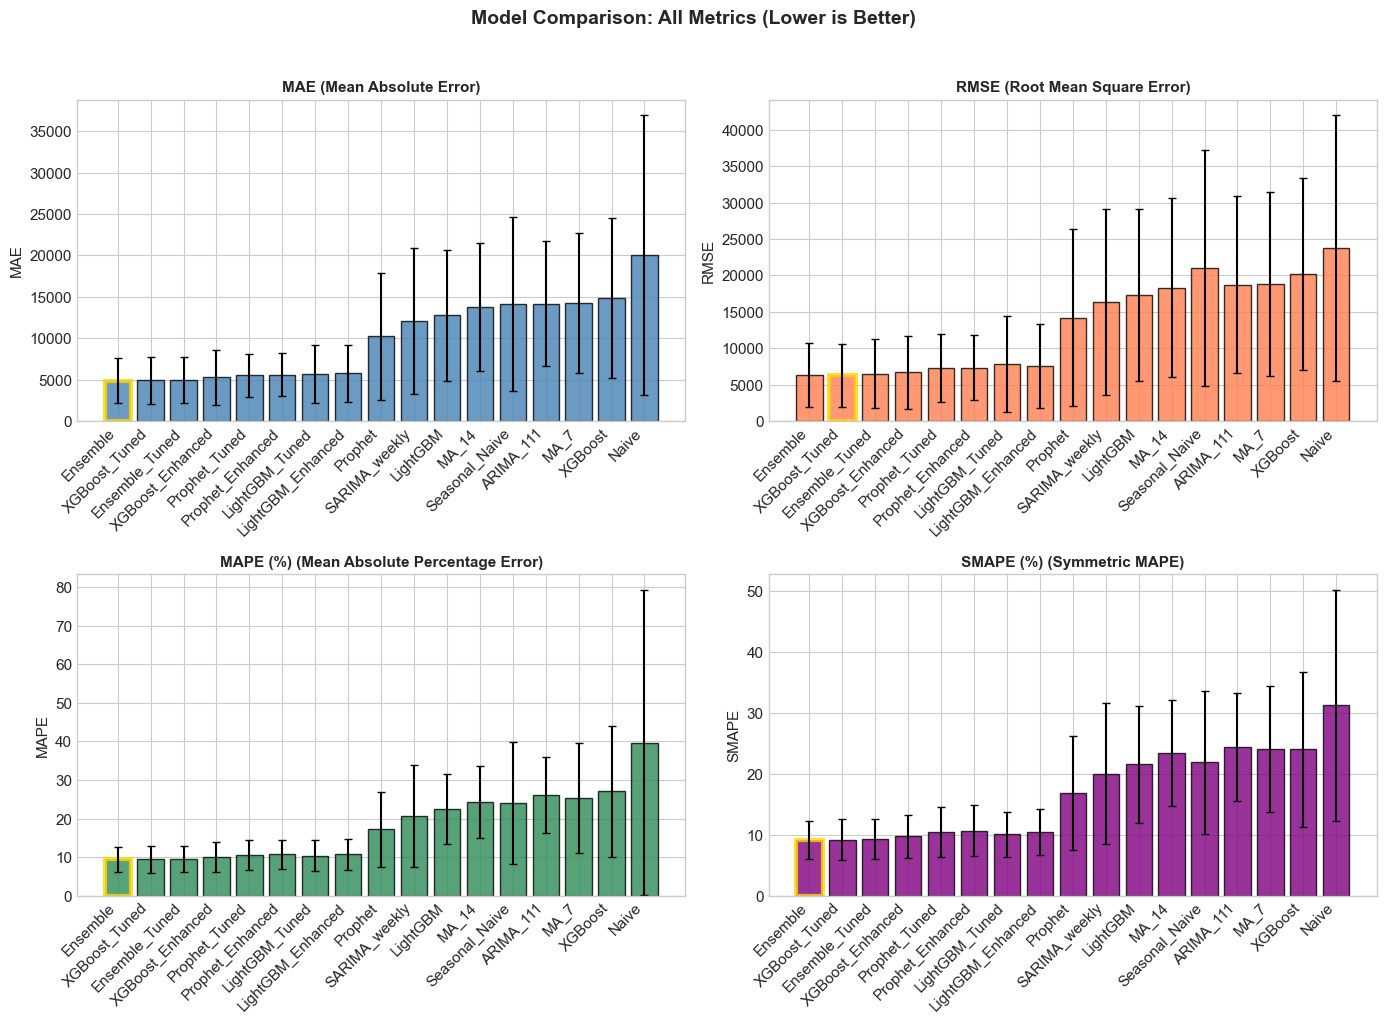

In [14]:
# Bar chart comparison of metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_info = [
    ('mae_mean', 'mae_std', 'MAE (Mean Absolute Error)', 'steelblue'),
    ('rmse_mean', 'rmse_std', 'RMSE (Root Mean Square Error)', 'coral'),
    ('mape_mean', 'mape_std', 'MAPE (%) (Mean Absolute Percentage Error)', 'seagreen'),
    ('smape_mean', 'smape_std', 'SMAPE (%) (Symmetric MAPE)', 'purple')
]

# Sort by MAE for consistent ordering
sorted_df = comparison_df.sort_values('mae_mean')
model_names = sorted_df.index.tolist()

for ax, (mean_col, std_col, title, color) in zip(axes.flatten(), metrics_info):
    means = sorted_df[mean_col].values
    stds = sorted_df[std_col].values
    
    bars = ax.bar(range(len(model_names)), means, color=color, alpha=0.8, edgecolor='black')
    ax.errorbar(range(len(model_names)), means, yerr=stds, fmt='none', color='black', capsize=3)
    
    ax.set_xticks(range(len(model_names)))
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylabel(title.split('(')[0].strip())
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    # Highlight best model
    best_idx = np.argmin(means)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

plt.suptitle('Model Comparison: All Metrics (Lower is Better)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.2 Boxplots: Fold-Level Results Distribution

To create boxplots, we need to collect fold-level metrics for each model.

In [15]:
# Collect fold-level results for each model
fold_results_list = []

print("Collecting fold-level results for boxplots...")

for model in models:
    # Re-run validation for this model to get fold-level metrics
    # Pass feature columns for enhanced models that need external features
    fold_results = validator.validate(
        model, df_features, target=TARGET, date_column='date',
        feature_columns=EXTERNAL_FEATURES + ['date']
    )
    
    for result in fold_results:
        fold_results_list.append({
            'model': model.name,
            'fold': result['fold_id'],
            'mae': result['metrics']['mae'],
            'rmse': result['metrics']['rmse'],
            'mape': result['metrics']['mape'],
            'smape': result['metrics']['smape']
        })

fold_df = pd.DataFrame(fold_results_list)
print(f"Collected {len(fold_df)} fold results ({len(models)} models x {n_folds} folds)")
fold_df.head()

Collected 884 fold results (17 models x 52 folds)


,model,fold,mae,rmse,mape,smape
0,Naive,0,21832.8571,32830.9106,32.1535,30.7916
1,Naive,1,15072.8571,16944.7531,26.2684,24.2798
2,Naive,2,46710.5714,47220.2027,101.4279,66.1348
3,Naive,3,17773.5714,24736.4534,27.3453,28.4684
4,Naive,4,63702.7143,64007.0867,131.8472,78.7477


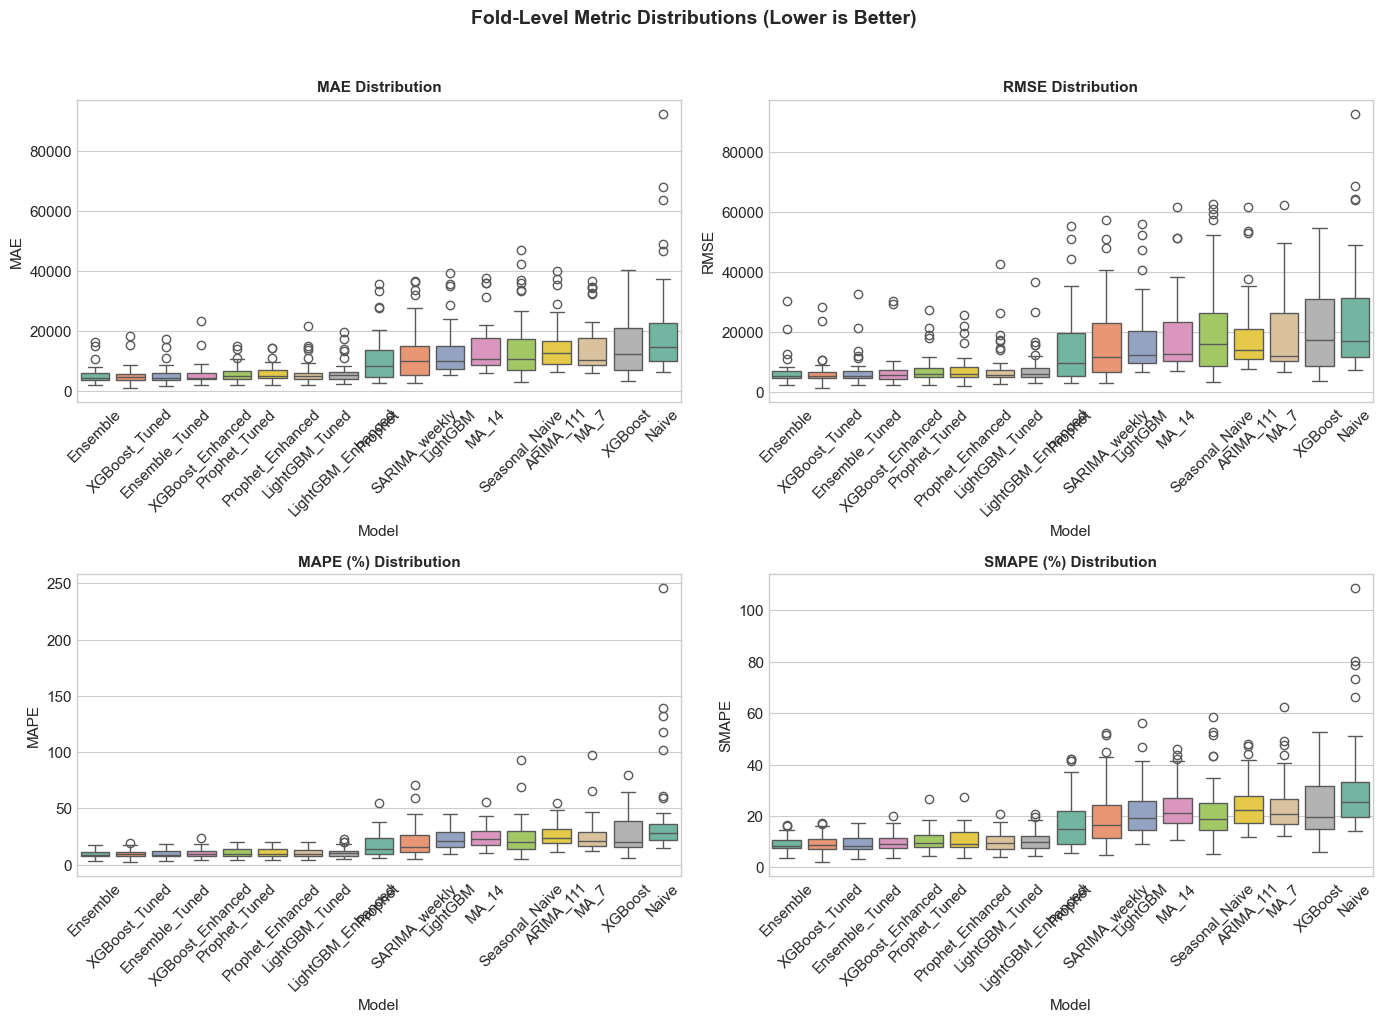

In [16]:
# Create boxplots for fold-level distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Order models by mean MAE
model_order = comparison_df.sort_values('mae_mean').index.tolist()

metrics_labels = [
    ('mae', 'MAE Distribution'),
    ('rmse', 'RMSE Distribution'),
    ('mape', 'MAPE (%) Distribution'),
    ('smape', 'SMAPE (%) Distribution')
]

for ax, (metric, title) in zip(axes.flatten(), metrics_labels):
    sns.boxplot(data=fold_df, x='model', y=metric, order=model_order, ax=ax, palette='Set2')
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.upper())
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Fold-Level Metric Distributions (Lower is Better)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 7.3 Heatmap: Model Rankings

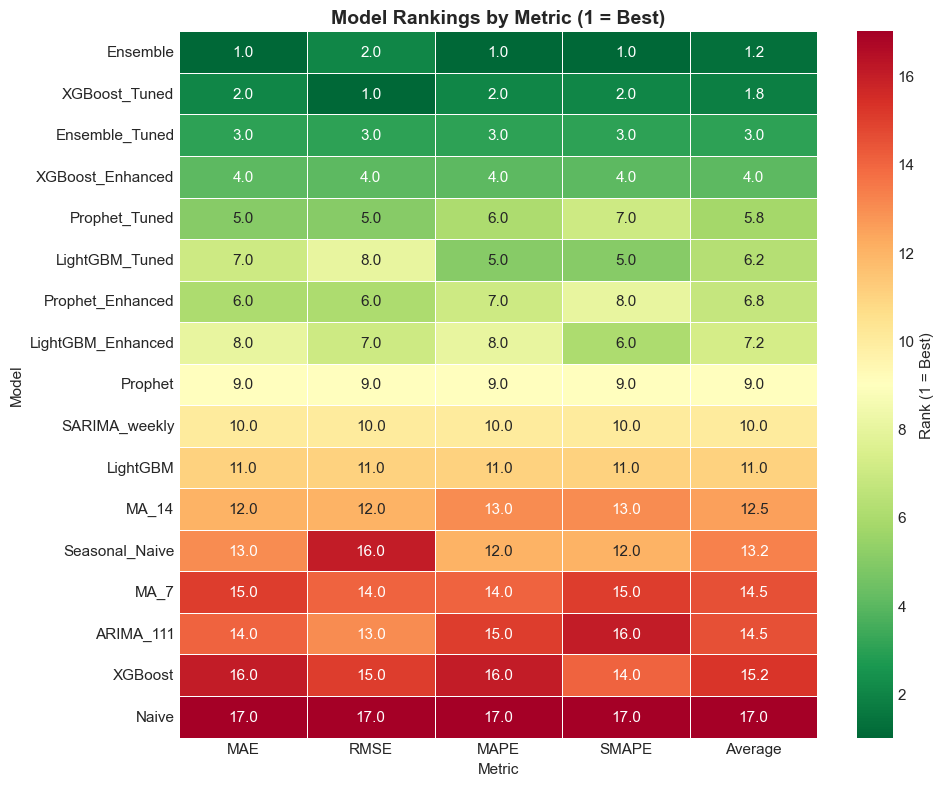

In [17]:
# Create ranking heatmap
rank_data = pd.DataFrame(index=comparison_df.index)
for metric in ['mae', 'rmse', 'mape', 'smape']:
    rank_data[metric.upper()] = comparison_df[f'{metric}_mean'].rank().astype(int)

rank_data['Average'] = rank_data.mean(axis=1)
rank_data = rank_data.sort_values('Average')

fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(rank_data, annot=True, cmap='RdYlGn_r', fmt='.1f', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Rank (1 = Best)'})

ax.set_title('Model Rankings by Metric (1 = Best)', fontsize=14, fontweight='bold')
ax.set_xlabel('Metric')
ax.set_ylabel('Model')

plt.tight_layout()
plt.show()

### 7.4 Performance Across Folds Over Time

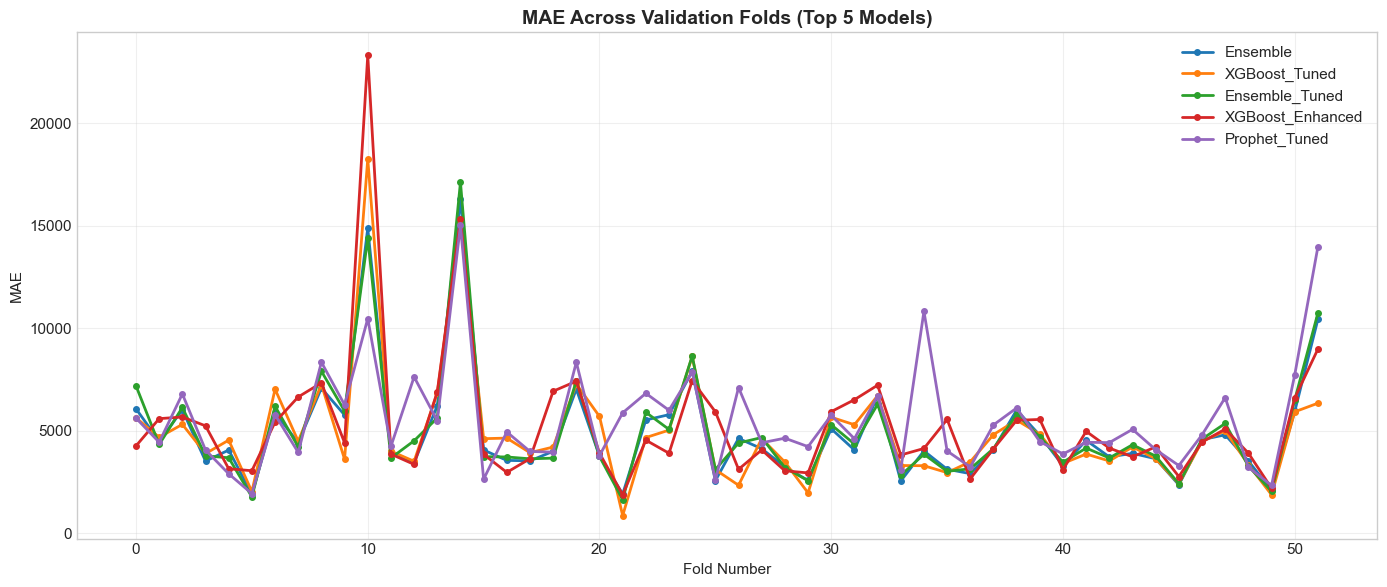

In [18]:
# Plot MAE across folds for top models
top_models = comparison_df.sort_values('mae_mean').head(5).index.tolist()

fig, ax = plt.subplots(figsize=(14, 6))

for model_name in top_models:
    model_folds = fold_df[fold_df['model'] == model_name]
    ax.plot(model_folds['fold'], model_folds['mae'], marker='o', label=model_name, linewidth=2, markersize=4)

ax.set_xlabel('Fold Number')
ax.set_ylabel('MAE')
ax.set_title('MAE Across Validation Folds (Top 5 Models)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Best Model Selection

In [19]:
# Get best model based on MAE
best_model = benchmark.get_best_model(metric='mae')
best_model_results = comparison_df.loc[best_model.name]

print("=" * 70)
print("BEST MODEL SELECTION")
print("=" * 70)
print(f"\nBest Model (by MAE): {best_model.name}")
print(f"Model Type: {type(best_model).__name__}")
print(f"\nPerformance Metrics:")
print(f"  MAE:   {best_model_results['mae_mean']:.2f} (+/- {best_model_results['mae_std']:.2f})")
print(f"  RMSE:  {best_model_results['rmse_mean']:.2f} (+/- {best_model_results['rmse_std']:.2f})")
print(f"  MAPE:  {best_model_results['mape_mean']:.2f}% (+/- {best_model_results['mape_std']:.2f}%)")
print(f"  SMAPE: {best_model_results['smape_mean']:.2f}% (+/- {best_model_results['smape_std']:.2f}%)")

print(f"\nModel Parameters:")
for param, value in best_model.get_params().items():
    print(f"  {param}: {value}")

BEST MODEL SELECTION

Best Model (by MAE): Ensemble
Model Type: EnsembleModel

Performance Metrics:
  MAE:   4901.33 (+/- 2679.22)
  RMSE:  6295.90 (+/- 4408.16)
  MAPE:  9.44% (+/- 3.29%)
  SMAPE: 9.18% (+/- 3.15%)

Model Parameters:
  name: Ensemble
  weighting: inverse_mae
  model_names: ['Ens_XGB', 'Ens_LGB', 'Ens_Prophet']
  weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [20]:
# Show rankings for all metrics
print("\nBest Models by Each Metric:")
print("-" * 50)

for metric in ['mae', 'rmse', 'mape', 'smape']:
    best = benchmark.get_best_model(metric=metric)
    value = comparison_df.loc[best.name, f'{metric}_mean']
    print(f"  {metric.upper():6s}: {best.name:20s} ({value:.2f})")


Best Models by Each Metric:
--------------------------------------------------
  MAE   : Ensemble             (4901.33)
  RMSE  : XGBoost_Tuned        (6287.03)
  MAPE  : Ensemble             (9.44)
  SMAPE : Ensemble             (9.18)


## 9. Model Category Comparison

Compare performance by model category (Baseline vs Statistical vs ML).

In [21]:
# Categorize models
def get_model_category(model_name):
    baseline_names = ['Naive', 'Seasonal_Naive', 'MA_7', 'MA_14']
    statistical_names = ['ARIMA_111', 'SARIMA_weekly', 'Prophet', 'Prophet_Enhanced']
    ml_names = ['XGBoost', 'LightGBM', 'XGBoost_Enhanced', 'LightGBM_Enhanced']
    
    if model_name in baseline_names:
        return 'Baseline'
    elif model_name in statistical_names:
        return 'Statistical'
    elif model_name in ml_names:
        return 'ML'
    else:
        return 'Other'

# Add category to fold results
fold_df['category'] = fold_df['model'].apply(get_model_category)

# Calculate category-level statistics
category_stats = fold_df.groupby('category').agg({
    'mae': ['mean', 'std'],
    'rmse': ['mean', 'std'],
    'mape': ['mean', 'std']
}).round(2)

category_stats.columns = ['_'.join(col) for col in category_stats.columns]
print("\nPerformance by Model Category:")
print("=" * 60)
category_stats


Performance by Model Category:


,mae_mean,mae_std,rmse_mean,rmse_std,mape_mean,mape_std
category,,,,,,
Baseline,15547.3100,11781.5900,20476.2800,15224.8900,28.3600,23.9600
ML,9688.1400,7910.4100,12944.9200,11313.8800,17.5700,12.4800
Other,5209.7100,2925.2900,6841.0400,5060.7100,9.8800,3.6600
Statistical,10545.4700,7768.5700,14160.7400,11716.5400,18.6500,11.3000


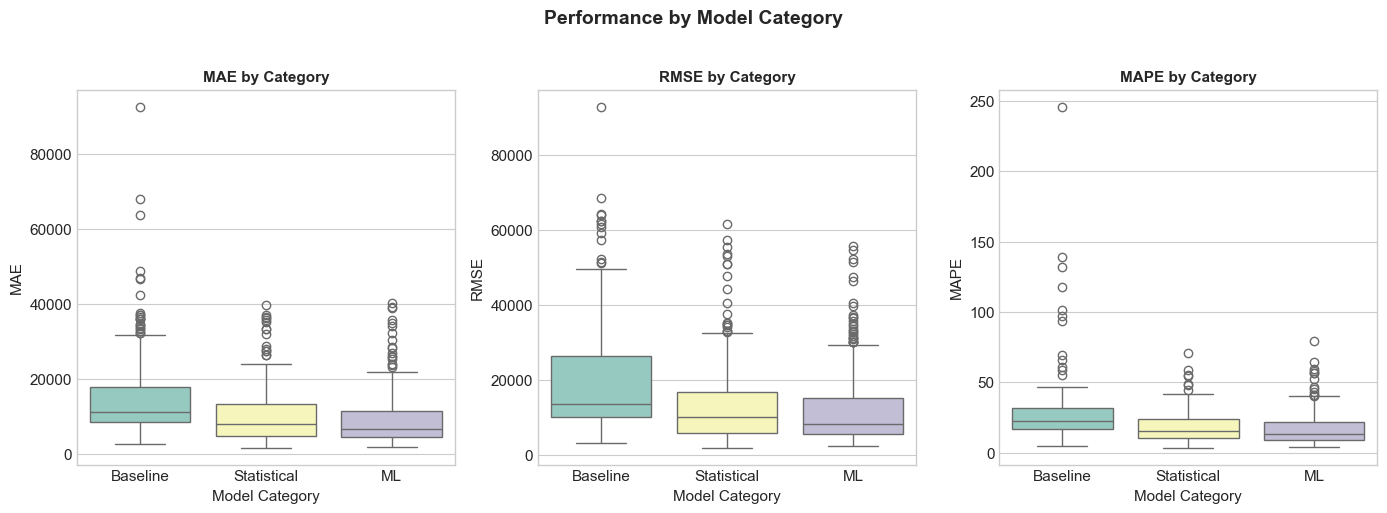

In [22]:
# Boxplot by category
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

category_order = ['Baseline', 'Statistical', 'ML']
available_categories = [c for c in category_order if c in fold_df['category'].unique()]

for ax, metric in zip(axes, ['mae', 'rmse', 'mape']):
    sns.boxplot(data=fold_df, x='category', y=metric, order=available_categories, 
                ax=ax, palette='Set3')
    ax.set_xlabel('Model Category')
    ax.set_ylabel(metric.upper())
    ax.set_title(f'{metric.upper()} by Category', fontsize=11, fontweight='bold')

plt.suptitle('Performance by Model Category', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 10. Discussion and Recommendations

### Key Findings

In [23]:
# Generate findings summary
best_overall = comparison_df['mae_mean'].idxmin()
best_baseline = comparison_df.loc[comparison_df.index.isin(['Naive', 'Seasonal_Naive', 'MA_7', 'MA_14']), 'mae_mean'].idxmin()

# Calculate improvement over naive
naive_mae = comparison_df.loc['Naive', 'mae_mean']
best_mae = comparison_df.loc[best_overall, 'mae_mean']
improvement = ((naive_mae - best_mae) / naive_mae) * 100

print("=" * 70)
print("SUMMARY OF FINDINGS")
print("=" * 70)

print(f"""
1. BEST OVERALL MODEL: {best_overall}
   - MAE: {comparison_df.loc[best_overall, 'mae_mean']:.2f}
   - MAPE: {comparison_df.loc[best_overall, 'mape_mean']:.2f}%

2. BEST BASELINE MODEL: {best_baseline}
   - MAE: {comparison_df.loc[best_baseline, 'mae_mean']:.2f}
   - MAPE: {comparison_df.loc[best_baseline, 'mape_mean']:.2f}%

3. IMPROVEMENT OVER NAIVE: {improvement:.1f}%
   - Naive MAE: {naive_mae:.2f}
   - Best MAE: {best_mae:.2f}

4. MODEL STABILITY:
   - Lowest variance: {comparison_df['mae_std'].idxmin()} (MAE std: {comparison_df['mae_std'].min():.2f})
   - Highest variance: {comparison_df['mae_std'].idxmax()} (MAE std: {comparison_df['mae_std'].max():.2f})
""")

SUMMARY OF FINDINGS

1. BEST OVERALL MODEL: Ensemble
   - MAE: 4901.33
   - MAPE: 9.44%

2. BEST BASELINE MODEL: MA_14
   - MAE: 13742.18
   - MAPE: 24.38%

3. IMPROVEMENT OVER NAIVE: 75.6%
   - Naive MAE: 20055.61
   - Best MAE: 4901.33

4. MODEL STABILITY:
   - Lowest variance: Prophet_Enhanced (MAE std: 2572.19)
   - Highest variance: Naive (MAE std: 16884.26)



### Recommendations

Based on the walk-forward validation results:

1. **Production Deployment**: The best model should be selected based on the trade-off between accuracy and complexity:
   - If simplicity is valued: Use the best baseline model (likely Seasonal Naive or Moving Average)
   - If accuracy is paramount: Use the overall best model
   
2. **Model Stability**: Consider not just mean performance but also variance across folds. A model with slightly higher MAE but lower variance may be preferable in production.

3. **Computational Cost**: 
   - Baseline models: Near-instant training and prediction
   - Statistical models (ARIMA, Prophet): Moderate training time
   - ML models: Higher training time, but often better accuracy

4. **Further Improvements**:
   - Feature engineering (add holiday indicators, lag features)
   - Ensemble methods (combine top performers)
   - Hyperparameter tuning for ML models
   - Include external regressors (events, weather, etc.)

## 11. Save Results

In [24]:
# Save comparison results
results_path = project_root / "data" / "processed" / "model_comparison_results.csv"
results_path.parent.mkdir(parents=True, exist_ok=True)

# Save full results
comparison_df.to_csv(results_path)
print(f"Comparison results saved to: {results_path}")

# Save fold-level results
fold_results_path = project_root / "data" / "processed" / "model_comparison_folds.csv"
fold_df.to_csv(fold_results_path, index=False)
print(f"Fold-level results saved to: {fold_results_path}")

Comparison results saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\model_comparison_results.csv
Fold-level results saved to: C:\Users\juanlu\dev\volume-forecasting-poc\data\processed\model_comparison_folds.csv


## 12. Final Summary Table

In [25]:
# Create final summary table
final_summary = comparison_df[['mae_mean', 'rmse_mean', 'mape_mean', 'smape_mean']].copy()
final_summary.columns = ['MAE', 'RMSE', 'MAPE (%)', 'SMAPE (%)']

# Add ranks
for col in final_summary.columns:
    final_summary[f'{col}_Rank'] = final_summary[col].rank().astype(int)

# Calculate average rank
rank_cols = [col for col in final_summary.columns if col.endswith('_Rank')]
final_summary['Avg_Rank'] = final_summary[rank_cols].mean(axis=1)

# Sort by average rank
final_summary = final_summary.sort_values('Avg_Rank')

# Display with styling
print("\n" + "=" * 80)
print("FINAL MODEL RANKINGS")
print("=" * 80)
print(f"\nBased on {n_folds}-fold walk-forward validation")
print(f"Target: {TARGET} | Horizon: {TEST_SIZE} days\n")

# Show main metrics
final_summary[['MAE', 'RMSE', 'MAPE (%)', 'SMAPE (%)', 'Avg_Rank']].round(2)


FINAL MODEL RANKINGS

Based on 52-fold walk-forward validation
Target: daily_logins | Horizon: 7 days



,MAE,RMSE,MAPE (%),SMAPE (%),Avg_Rank
model_name,,,,,
Ensemble,4901.3300,6295.9000,9.4400,9.1800,1.2500
XGBoost_Tuned,4919.0600,6287.0300,9.4800,9.2100,1.7500
Ensemble_Tuned,4998.7300,6537.5000,9.5100,9.2400,3.0000
XGBoost_Enhanced,5285.3400,6692.5200,10.0000,9.7100,4.0000
Prophet_Tuned,5551.0200,7297.1500,10.6100,10.5000,5.7500
LightGBM_Tuned,5678.4200,7787.5900,10.3600,10.0400,6.2500
Prophet_Enhanced,5615.3000,7364.4800,10.7100,10.6400,6.7500
LightGBM_Enhanced,5790.3700,7590.2200,10.7400,10.4000,7.2500
Prophet,10256.7100,14196.4600,17.2100,16.8700,9.0000


---

**End of Notebook 07 - Comprehensive Model Comparison**

This notebook has demonstrated:
1. Walk-forward validation methodology for time series
2. Comprehensive comparison of baseline, statistical, and ML models
3. Multiple visualization techniques for model comparison
4. Best model selection and recommendations